In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
pandas.set_option('display.max_colwidth', 200)

In [2]:
# preprocessing

def cleanup(tweets):
    tweets = tweets.dropna()
    tweets = tweets.drop(columns=['Id'])
    tweets = tweets[tweets.Category != 'Tweet']
    tweets = tweets[tweets.Tweet != 'Not Available']
    tweets = tweets[tweets.Tweet != '']
    return tweets

import re
from nltk.tokenize.casual import casual_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
import string

# stops = set(stopwords.words('english'))
stops = {'in', 'of', 'at', 'a', 'the', 'to', 'on', 'and', 'it'}
stops.update(string.punctuation)
stops.difference_update('?!')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def tag_for_lemmatizer(tag):
    if tag.startswith('NN'):
        return 'n'
    if tag.startswith('VB'):
        return 'v'
    return 'a'

def preprocess(text, lemmatize=True):
    if not text or type(text) != str:
        return ''

    text = text.lower()
    text = re.sub(r"https?://[^\s]+", '', text) # hyperlinks
    text = re.sub(r"\@\w+", '', text) # mentions
    text = re.sub(r"#", '', text) # hashtags
    text = re.sub(r"\d+\w*", '', text) # numbers
    text = re.sub(r"'s", '', text) # possesive
    text = re.sub(r"n't", ' not', text) # contractions
    
    words = [word for word in casual_tokenize(text) if word not in stops]
    
    if lemmatize:
        words = [
            lemmatizer.lemmatize(word, tag_for_lemmatizer(tag))
            for word, tag in pos_tag(words)
        ]
    else:
        words = [
            stemmer.stem(word)
            for word in words
        ]
    text = ' '.join(words)
    return text

In [3]:
# load train set

tweets = pandas.read_csv('data/train.csv')
tweets = cleanup(tweets)
tweets.Tweet = tweets.Tweet.apply(preprocess, lemmatize=True)
tweets

,Category,Tweet
1,neutral,io app transport security mm need check if my party network pod support
2,neutral,mar if you have an ios device you should download our app too
3,negative,my phone do not run late io which may account for problem other day .. time be replace
4,positive,not sure how start your publication io ? we'll be live help with ask me anything session today friday
5,neutral,two dollar tuesday be here with forklift quickkey for io suite for page for just today
...,...,...
5963,positive,ok ed let do this zlatan greizmann laporte tomorrow make happen
5964,neutral,goal level zlatan by friday ? post every other day dsgs vine by
5965,neutral,would not surprise me if we enquired.he ca not be happy play fiddle zlatan but he not worth psg ask price
5966,neutral,rib injury for zlatan against russia be big blow if he miss austria game tuesday chance for new sunderland striker toivonen safc


In [4]:
# convert text to sequences

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets.Tweet)
vocab_size = len(tokenizer.word_index) + 1

sequences = tokenizer.texts_to_sequences(tweets.Tweet)

Using TensorFlow backend.


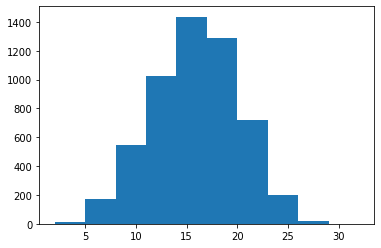

array([[   0,    0,    0, ...,  909, 4082,  284],
       [   0,    0,    0, ...,  123,  419,  212],
       [   0,    0,    0, ...,   24,    1,  910],
       ...,
       [   0,    0,    0, ...,  652,  289,  760],
       [   0,    0,    0, ..., 1021, 9218, 9219],
       [   0,    0,    0, ...,   66,  465,  335]], dtype=int32)

In [5]:
# pad sequences

lengths = [len(seq) for seq in sequences]
plt.hist(lengths)
plt.show()

max_words = 30
sequences = sequence.pad_sequences(sequences, maxlen=max_words)
sequences

In [6]:
# convert categories to one-hot vectors

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(tweets.Category.values.reshape(-1, 1))
num_classes = len(ohe.get_feature_names())

In [7]:
# split data

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(sequences, y, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

In [61]:
# setup and train neural network

from keras import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense

embedding_dim = 100

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_words),
    SpatialDropout1D(0.5),
    LSTM(100, dropout=0.5, recurrent_dropout=0.5),
    Dense(num_classes, activation='softmax'),
])
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 3
batch_size = 32

model.fit(x_train, y_train,
          validation_data=(x_valid, y_valid),
          epochs=epochs, batch_size=batch_size)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 30, 100)           922100    
_________________________________________________________________
spatial_dropout1d_20 (Spatia (None, 30, 100)           0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 303       
Total params: 1,002,803
Trainable params: 1,002,803
Non-trainable params: 0
_________________________________________________________________


/Users/mikolaj/Code/iti2/emd/lab2/.venv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3468 samples, validate on 868 samples
Epoch 1/3
3468/3468 [==============================] - 4s 1ms/step - loss: 1.0249 - accuracy: 0.4686 - val_loss: 0.9695 - val_accuracy: 0.5207
Epoch 2/3
3468/3468 [==============================] - 6s 2ms/step - loss: 0.9578 - accuracy: 0.5202 - val_loss: 0.8511 - val_accuracy: 0.6025
Epoch 3/3
3468/3468 [==============================] - 8s 2ms/step - loss: 0.8297 - accuracy: 0.6130 - val_loss: 0.8424 - val_accuracy: 0.6002


In [62]:
# check against the test set

from sklearn.metrics import confusion_matrix, accuracy_score

predictions = model.predict_classes(x_test)
truth = y_test.argmax(1)

print(confusion_matrix(truth, predictions))
print(accuracy_score(truth, predictions))

[[ 48  92  33]
 [ 46 206 151]
 [ 13 118 378]]
0.5824884792626728


In [63]:
# test on our own input

def classify(text):
    text = preprocess(text)
    test_seq = tokenizer.texts_to_sequences([text])
    test_seq = sequence.pad_sequences(test_seq, maxlen=max_words)
    predictions = model.predict_classes(test_seq)
    return ohe.categories_[0][predictions[0]]

phrases = ["I loved it!", "I don't know what to say", "What a fucking piece of shit"]
{ phrase: classify(phrase) for phrase in phrases }

{'I loved it!': 'positive',
 "I don't know what to say": 'neutral',
 'What a fucking piece of shit': 'negative'}

In [67]:
# predict categories on the external test set

def classify_array(texts):
    texts = [preprocess(text) for text in texts]
    sequences = tokenizer.texts_to_sequences(texts)
    sequences = sequence.pad_sequences(sequences, maxlen=max_words)
    predictions = model.predict_classes(sequences)
    return ohe.categories_[0][predictions]

test_tweets = pandas.read_csv('data/test.csv', dtype={'Id': str, 'Tweet': str})
test_tweets['Category'] = classify_array(test_tweets.Tweet)

with open('predictions_lstm.csv', 'wt') as f:
    f.write("Id,Category\n")
    for i, row in test_tweets.iterrows():
        f.write(f"{row.Id},{row.Category}\n")

In [68]:
print(test_tweets.Category.value_counts(normalize=True))
test_tweets[['Tweet', 'Category']].tail(20)

neutral     0.5315
positive    0.4185
negative    0.0500
Name: Category, dtype: float64


,Tweet,Category
3980,Trynna go to IHOP but all my friends are asleep so I may just go by myself #WHENINDOUBTPANCAKEITOUT,neutral
3981,IHOP wit bubba jay @GuwopoGodd_ tomorrow he better eat too,positive
3982,EMT 09/06/15 [krakatoa]: So when the high point of your Saturday is a chorizo omelette at IHOP for a late dinn... http://t.co/LyXuMPFf8o,positive
3983,Who's down to go IHOP with me tomorrow morning?,neutral
3984,@GaPeach_est1083 Me either...but we got off early friday so some coworkers went to IHOP...and the rest was history,positive
3985,definitely going to ihop tomorrow,neutral
3986,Get paid next Friday so I get to buy Koko and I some food from IHOP after the game,positive
3987,@LebronRuben_ dude I swear Friday I was going to go take you to ihop but Danny had to go home cus he was in pain,neutral
3988,@jbach14 If i didnt have work at 9am tomorrow i really would man. Bring your family to Ihop tomorrow morning and illserve you,positive
3989,I'm going to IHOP tomorrow.,neutral
